## Notebook to test a modfied DeepONet on a 1d Burgers example

Consider the one-dimensional viscous Burgers' equation with Dirichlet boundary conditions which can be represented as 
\begin{align}
\dot{u} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},\\
u(x,0) = u_0, \qquad x \in [0,L], \qquad u(0,t) = u(L.t) = 0
\end{align}

Consider the initial condition
\begin{align}
u(x,0) = \frac{x}{1 + \sqrt{\frac{1}{t_0}} \exp{\left(Re \frac{x^2}{4} \right)}},
\end{align}

Set $L=1$ and maximum time $t_{max} = 2$. An analytical solution exists and is given by 
\begin{align}
u(x,t) =  \frac{\frac{x}{t+1}}{1 + \sqrt{\frac{t+1}{t_0}} \exp{\left(Re \frac{x^2}{4t+4} \right)}}
\end{align}

where $t_0 = \exp{(Re/8)}$ and $Re = 1/\nu$.

In [1]:
import json
import os
import sys
import argparse
import time
from datetime import datetime

import tensorflow as tf

### -----------------
### SD added
## Used to suppress TF warnings about 'weighted_metrics' and 'sample_weights'
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
## USE the above to suppress all warning except ERROR. Do not use if debugging or prototyping
### -----------------

# import keras_tuner
tf.keras.backend.set_floatx('float64') 


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae


from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, # fontsize for x and y labels (was 10)
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x',]) #'D','H','v','*'])


from pathlib import Path, PurePath
try:
    base_dir.exists()
except:
    curr_dir = Path().resolve()
    base_dir = curr_dir.parent  

scripts_dir = base_dir / "scripts"
work_dir = base_dir / "Burgers"
data_dir = base_dir / "Burgers" / "functions"
model_dir = work_dir / "Saved_DON_models"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)


sys.path.append(str(scripts_dir.absolute()))
sys.path.append(str(work_dir.absolute()))
sys.path.append(str(data_dir.absolute()))


import modified_don as don
import burgers_exact as bg

%matplotlib inline

In [2]:
case='Train' #or 'Predict'

if case == 'Predict':
    
    ## Replace below with appropriate timestamp of saved model
    model_path = model_dir+'_burgers1d_'+timestamp_don

    loaded_model = tf.keras.models.load_model(model_path)
    branch_id = np.load(model_path+'/branch_id.npy')

train_epochs=100
loss='mse'
optimizer_str='adam'
scaling=False
scaler_min=0
scaler_max=1
re_train_list=[15,25,35,50,70,100,200,400,800]
re_val_list=[10,1000]
re_test_list=[10,30,75,150,300,600,1000]
x_extent_train=0.8
t_extent_train=1.6
x_extent_val=1
t_extent_val=2
percent_branch=0.05
percent_trunk=0.05


In [3]:
def define_grid(L, T, vxn, vtn):
    vx = np.linspace(0,L,vxn)
    vt = np.linspace(0,T,vtn)
    return vx, vt

def plot_bounds_1d(p1,p2,p3,L,T, label1=None, vmin1=None, vmax1=None, name=None):
    
    if vmin1 is None:
        vmin1 = np.amin([p1.min(), p2.min()])
        vmax1 = np.amax([p1.max(), p2.max()])

    fig, ((ax1), (ax2), (ax3)) = plt.subplots(1,3, figsize=(20,3))
    pcm1 = ax1.imshow(p1,cmap='jet',origin='lower',
                      vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.79)
    ax1.yaxis.set_ticks(np.arange(0,L+0.1,1))
    fig.colorbar(pcm1,ax=ax1)
    ax1.set_title('Truth' +'\n'+ '%s = %.2f'%('Re', label1)+'\n'+
                 '%.4f<u<%.4f'%(tf.reduce_min(p1).numpy(), tf.reduce_max(p1).numpy()))
    pcm2 = ax2.imshow(p2,cmap='jet',origin='lower',
                      vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.79)
    ax2.yaxis.set_ticks(np.arange(0,L+0.1,1))

    fig.colorbar(pcm2,ax=ax2)
    ax2.set_title('Prediction' +'\n'+ '%s = %.2f'%('Re', label1)+'\n'
                 '%.4f<u<%.4f'%(tf.reduce_min(p2).numpy(), tf.reduce_max(p2).numpy()))
    pcm3 = ax3.imshow(p3,cmap='coolwarm',origin='lower',
                      vmin=-0.05, vmax=0.05, extent=(0,T,0,L), aspect = 0.79)
    ax3.yaxis.set_ticks(np.arange(0,L+0.1,1))

    cbar = fig.colorbar(pcm3,ax=ax3)
    ax3.set_title('Relative Error' +'\n'+ '%s = %.2f'%('Re', label1))
    
    ax1.set_ylabel('$x$',fontsize=18)
    ax1.set_xlabel('$t$',fontsize=18)
    ax2.set_xlabel('$t$',fontsize=18) 
    ax3.set_xlabel('$t$',fontsize=18)
    
    fig.tight_layout()
#     plt.savefig(name)

def plot_spcaetime_1d(p1,p2,p3,p4,p5,p6,T,L, colormap='jet', label1=None, label2=None, vmin1=None, vmax1=None, name=None):
    """
    Plot space-time 2d plots of 1D solutions
    Row1 : Predicted, True, Error for Soln1
    Row2 : Predicted, True, Error for Soln2
    """
    f = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(3, 3, )
    gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes.

    if vmin1 is None:
        vmin1 = np.amin([p1.min(), p2.min(), p3.min(), p4.min()])
        vmax1 = np.amax([p1.max(), p2.max(), p3.max(), p4.max()])

    ax1 = plt.subplot(gs[0, 0]);
    f1= ax1.imshow(p1,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax1.yaxis.set_ticks(np.arange(0,L+0.1,1)); ax1.xaxis.set_ticks(np.arange(0,T+0.1,1))
    ax1.set_title('%s=%.2f'%('Re',label1[0]))

    ax2 = plt.subplot(gs[0, 1]);
    f2 = ax2.imshow(p2,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax2.yaxis.set_ticks(np.arange(0,L+0.1,1)); ax2.xaxis.set_ticks(np.arange(0,T+0.1,1))
    ax2.set_title('%s=%.2f'%('Re',label1[1]))

    ax3 = plt.subplot(gs[1, 0]);
    f3= ax3.imshow(p3,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax3.set_xticklabels([]); ax3.set_yticklabels([])
#     ax3.yaxis.set_ticks(np.arange(0,1.1,1))
    ax3.set_title('%s=%.2f'%('Re',label1[2]))

    ax4 = plt.subplot(gs[1, 1]);
    f4 = ax4.imshow(p4,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax4.set_xticklabels([]); ax4.set_yticklabels([])
    ax4.set_title('%s=%.2f'%('Re',label1[3]))
    
    ax5 = plt.subplot(gs[2, 0]);
    f5= ax5.imshow(p5,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax5.set_xticklabels([]); ax5.set_yticklabels([])
#     ax3.yaxis.set_ticks(np.arange(0,1.1,1))
    ax5.set_title('%s=%.2f'%('Re',label1[4]))

    ax6 = plt.subplot(gs[2, 1]);
    f6 = ax6.imshow(p6,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    cbar1 = f.colorbar(f6, ax=list((ax1, ax2, ax3, ax4, ax5, ax6)),orientation='horizontal',aspect=50, pad=0.1)
    ax6.set_xticklabels([]); ax6.set_yticklabels([])
    ax6.set_title('%s=%.2f'%('Re',label1[5]))

    ax1.set_ylabel('$x$',fontsize=18); #ax2.set_ylabel('$x$',fontsize=18);
    ax3.set_ylabel('$x$',fontsize=18); #ax4.set_ylabel('$x$',fontsize=18);

    ax5.set_xlabel('$t$',fontsize=18); ax6.set_xlabel('$t$',fontsize=18); 
    ax5.set_ylabel('$x$',fontsize=18); #ax6.set_ylabel('$x$',fontsize=18);
#     plt.savefig(name)


def multiple_burgers(Re_list,vxn,vx,vtn,vt,percent_branch,percent_trunk,id_branch=None):
    
    number_cases = len(Re_list)
    branch_sensors = int(vxn*percent_branch)
    trunk_sensors = int(vtn*vxn*percent_trunk)
    
    burgers_array = np.zeros((number_cases,vxn,vtn))
    burgers_flatten = np.zeros((number_cases*vxn*vtn))
    count = 0 
    id0 = 0
    id1 = vxn*vtn
    
    for Re in Re_list:
        solution = np.zeros((vxn,vtn))
        for ix,vxi in enumerate(vx):
            solution[ix] = bg.true_solution(vxi,vt,Re)
        burgers_array[count] = solution
        burgers_flatten[id0:id1] = (solution.flatten())
        count = count + 1
        id0 = id1
        id1 = id1 + vxn*vtn
        
    b0 = burgers_array[:,:,0] #u0
    
    if id_branch is not None:
        id_b=np.zeros(np.shape(id_branch),dtype=int)
        for i in range(len(id_branch[0])):
            smallest=np.absolute(vx-id_branch[1][i])
            id_b[0][i]=int(np.argmin(smallest))
        id_b[1]=id_branch[1]    
    else:
        id_b = np.sort(np.random.choice(vxn, branch_sensors, replace=False))
        b_coords = vx[id_b]
        id_b = [id_b, b_coords]

    b0_train = b0[:,id_b[0]]

    
    T, X = np.meshgrid(vt,vx)
    for i in range(number_cases):
        b0_vector = np.tile(np.expand_dims(b0_train[i],1),vtn*vxn).T
        
        id_t = np.sort(np.random.choice(vtn*vxn, trunk_sensors, replace=False))
        
        if i == 0:
            b_input = b0_vector[id_t]
            t_input = np.hstack([T.flatten()[id_t,None], X.flatten()[id_t,None]])
            target = burgers_array[i,:,:].flatten()[id_t,None]

        else:
            b_input = np.vstack([b_input,b0_vector[id_t]])
            t_input = np.vstack([t_input,np.hstack([T.flatten()[id_t,None], X.flatten()[id_t,None]])])
            target = np.vstack([target,burgers_array[i,:,:].flatten()[id_t,None]])        
    
    return burgers_array, burgers_flatten, b_input, t_input, target, id_b

In [4]:
# Re_train = [15,25,50,75,100,150,200,300,400,600,800,900]
Re_train =  re_train_list
L_train =  x_extent_train
T_train =  t_extent_train
vxn = 300
vtn = 500
vx, vt = define_grid(L_train, T_train, vxn, vtn)
percent_branch =  percent_branch
percent_trunk =  percent_trunk
burgers_array_train, burgers_flatten_train, b_train, \
                    t_train, target_train, id_branch = multiple_burgers(Re_train,vxn,vx,vtn,vt,
                                                            percent_branch,percent_trunk)

if case == 'Predict':
    id_branch=branch_id
    
Re_val =  re_val_list
L_val =  x_extent_val
T_val =  t_extent_val
vxn = 300
vtn = 500
vx, vt = define_grid(L_val, T_val, vxn, vtn)
percent_branch =  percent_branch
percent_trunk =  percent_trunk
burgers_array_val, burgers_flatten_val, b_val, \
                    t_val, target_val, _ = multiple_burgers(Re_val,vxn,vx,vtn,vt,
                                                         percent_branch,percent_trunk,id_branch=id_branch)

Re_test =  re_test_list
L_test = L_val
T_test = T_val
vxn = 300
vtn = 500
vx, vt = define_grid(L_test, T_test, vxn, vtn)
percent_branch = 0.05
percent_trunk = 1
burgers_array_test, burgers_flatten_test, b_test, \
                    t_test, target_test, _ = multiple_burgers(Re_test,vxn,vx,vtn,vt, 
                                                              percent_branch,percent_trunk,id_branch)

if  scaling is True:
    x_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    t_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    u_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    b_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))

    x_scaler.fit(np.expand_dims(t_val[:,0],1))
    t_scaler.fit(np.expand_dims(t_val[:,1],1))
    u_scaler.fit(target_val)
    b_scaler.fit(b_val)

    t_train[:,0] = np.squeeze(x_scaler.transform(np.expand_dims(t_train[:,0],1)))
    t_train[:,1] = np.squeeze(t_scaler.transform(np.expand_dims(t_train[:,1],1)))
    b_train = b_scaler.transform(b_train)
    target_train = u_scaler.transform(target_train)
    
    t_val[:,0] = np.squeeze(x_scaler.transform(np.expand_dims(t_val[:,0],1)))
    t_val[:,1] = np.squeeze(t_scaler.transform(np.expand_dims(t_val[:,1],1)))
    b_val = b_scaler.transform(b_val)
    target_val = u_scaler.transform(target_val)
    
    t_test[:,0] = np.squeeze(x_scaler.transform(np.expand_dims(t_test[:,0],1)))
    t_test[:,1] = np.squeeze(t_scaler.transform(np.expand_dims(t_test[:,1],1)))
    b_test = b_scaler.transform(b_test)
    target_test = u_scaler.transform(target_test)       

In [5]:
branch_sensors = int(vxn* percent_branch)

nn = don.don_nn(branch_input_shape=branch_sensors, 
                 branch_output_shape=128,
                 b_number_layers=6, 
                 b_neurons_layer=256, 
                 b_actf='relu', 
                 b_init='glorot_normal', 
                 b_regularizer='l2', 
                 b_encoder_layers=4, 
                 b_encoder_neurons=128, 
                 b_encoder_actf='relu', 
                 b_encoder_init='glorot_normal', 
                 b_encoder_regularizer='l2', 
                 trunk_input_shape=2, 
                 trunk_output_shape=128,
                 t_number_layers=6, 
                 t_neurons_layer=256, 
                 t_actf='relu', 
                 t_init='glorot_normal', 
                 t_regularizer='l2', 
                 t_encoder_layers=4, 
                 t_encoder_neurons=128, 
                 t_encoder_actf='relu', 
                 t_encoder_init='glorot_normal', 
                 t_encoder_regularizer='l2'                
                )

model = don.don_model(nn)

#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,
#                               patience=100, min_lr=1e-6, min_delta=1e-10, verbose=1)

if optimizer_str == "adam":
    optimizer = tf.keras.optimizers.Adam()
elif optimizer_str == "rmsprop":   
    optimizer = tf.keras.optimizers.RMSprop()

if  loss == "mse":
    loss_obj = tf.keras.losses.MeanSquaredError()
elif  loss == "mae":   
    loss_obj = tf.keras.losses.MeanAbsoluteError()

model.compile(
    optimizer = optimizer,
    loss_fn = loss_obj)



# Prepare the dataset.
percent_trunk =  percent_trunk
batch_size = int(vtn*vxn*percent_trunk*len( re_train_list))

dataset = tf.data.Dataset.from_tensor_slices((b_train,t_train, target_train))
dataset = dataset.shuffle(buffer_size=batch_size).batch(batch_size)

batch_size = int(vtn*vxn* percent_trunk*len( re_val_list))

val_dataset = tf.data.Dataset.from_tensor_slices((b_val,t_val, target_val))
val_dataset = val_dataset.batch(batch_size)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=100, min_lr=1e-6, min_delta=1e-10, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-8,
    patience=500,
    verbose=1,
    restore_best_weights=True
)

i=1

timestamp_don = datetime.now().strftime("%Y-%m-%d_%H%M%S")
out_dir = os.path.join(model_dir, 'burgers1d_mdon_'+timestamp_don) 
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

    

if case == 'Train':
    
    init_time = time.time()
    
    # Train the model on all available devices.
    model.fit(dataset, validation_data=val_dataset, epochs= train_epochs,
                 callbacks=[tf.keras.callbacks.TensorBoard("tb/train_logs"+str(i)),reduce_lr,early_stop])
    
    end_time = time.time()
    train_time = end_time - init_time
    hrs = int(train_time//3600); rem_time = train_time - hrs*3600
    mins = int(rem_time//60); secs = int(rem_time%60)
    print('Training time: %d H %d M, %d S'%(hrs,mins,secs))
    
    
    model.save(out_dir,id_branch,)

if case == 'Predict':   
    model = loaded_model

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 0.0265 - val_loss: 0.0180 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 1s 532ms/step - loss: 0.0218 - val_loss: 0.0150 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 1s 523ms/step - loss: 0.0165 - val_loss: 0.0262 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 1s 524ms/step - loss: 0.0187 - val_loss: 0.0191 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 1s 515ms/step - loss: 0.0150 - val_loss: 0.0139 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 1s 527ms/step - loss: 0.0128 - val_loss: 0.0123 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 1s 517ms/step - loss: 0.0122 - val_loss: 0.0117 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 1s 514ms/step - loss: 0.0113 - val_loss: 0.0118 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - 1s 525ms/step - loss: 0.0101 - val_loss: 0.0143 - lr: 0.

1/1 [==============================] - 1s 509ms/step - loss: 0.0015 - val_loss: 0.0035 - lr: 0.0010
Epoch 74/100
1/1 [==============================] - 1s 518ms/step - loss: 0.0014 - val_loss: 0.0029 - lr: 0.0010
Epoch 75/100
1/1 [==============================] - 1s 517ms/step - loss: 0.0013 - val_loss: 0.0026 - lr: 0.0010
Epoch 76/100
1/1 [==============================] - 1s 524ms/step - loss: 0.0013 - val_loss: 0.0029 - lr: 0.0010
Epoch 77/100
1/1 [==============================] - 1s 543ms/step - loss: 0.0013 - val_loss: 0.0025 - lr: 0.0010
Epoch 78/100
1/1 [==============================] - 1s 525ms/step - loss: 0.0012 - val_loss: 0.0023 - lr: 0.0010
Epoch 79/100
1/1 [==============================] - 1s 518ms/step - loss: 0.0011 - val_loss: 0.0027 - lr: 0.0010
Epoch 80/100
1/1 [==============================] - 1s 534ms/step - loss: 0.0011 - val_loss: 0.0023 - lr: 0.0010
Epoch 81/100
1/1 [==============================] - 1s 550ms/step - loss: 0.0011 - val_loss: 0.0022 - lr: 0.0

Text(0.5, 1.0, 'Learning rate decay')

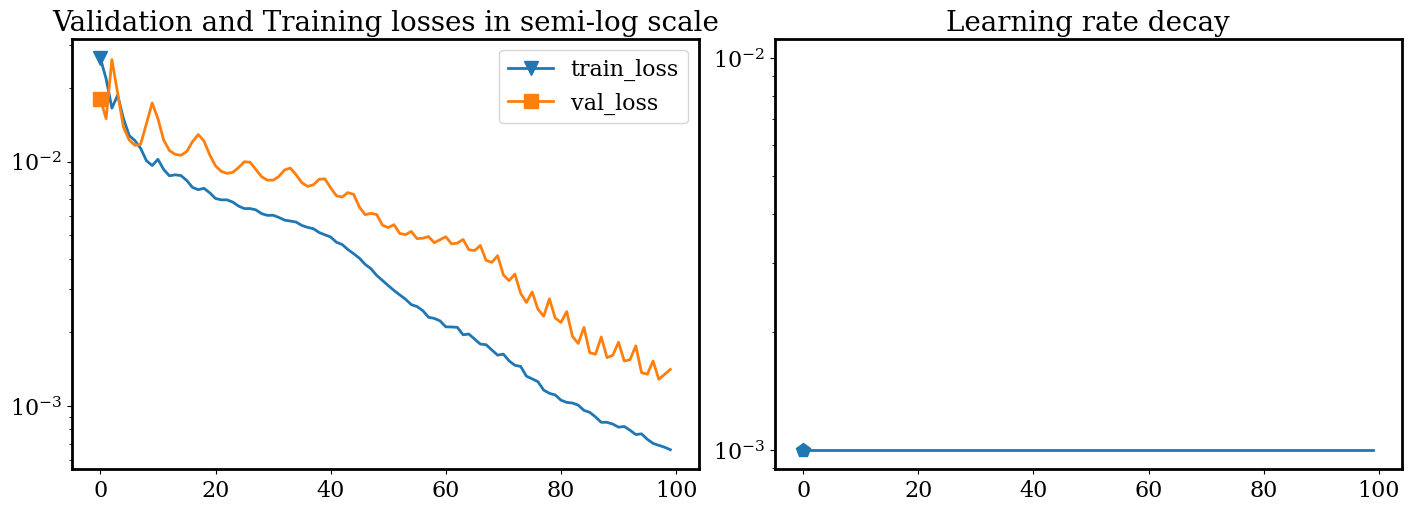

In [6]:

train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
lrate = model.history.history['lr']
train_epoch = model.history.epoch

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5),constrained_layout=True)
ax[0].plot(train_epoch,train_loss,label='train_loss',marker='v',markevery=128)
ax[0].plot(train_epoch,val_loss,label='val_loss',marker='s',markevery=128)

ax[0].set_yscale('log')
ax[0].set_title('Validation and Training losses in semi-log scale')
ax[0].legend()

ax[1].plot(train_epoch,lrate,label='LR',marker='p',markevery=128)
ax[1].set_yscale('log')

ax[1].set_title('Learning rate decay')

In [7]:
id_t = np.argmin(np.abs(vt-1.6))
id_x = np.argmin(np.abs(vx-0.8))

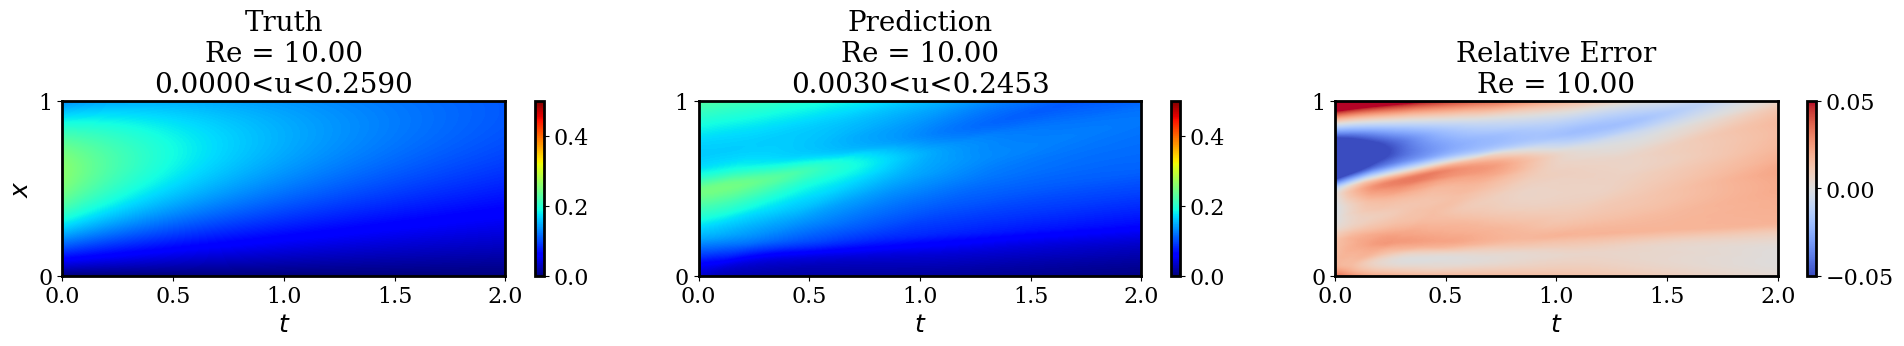

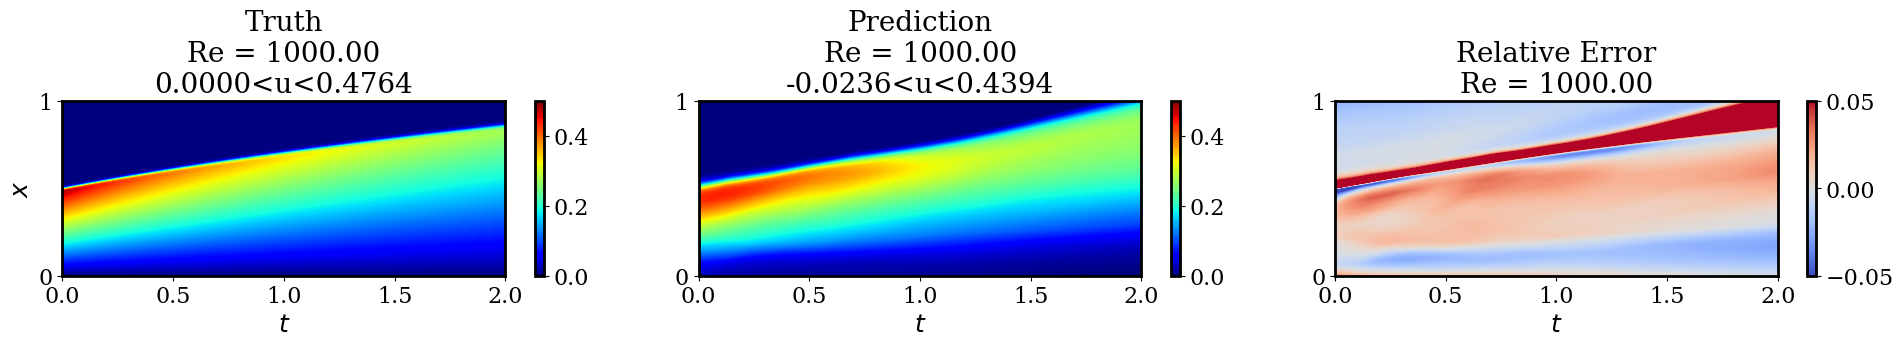

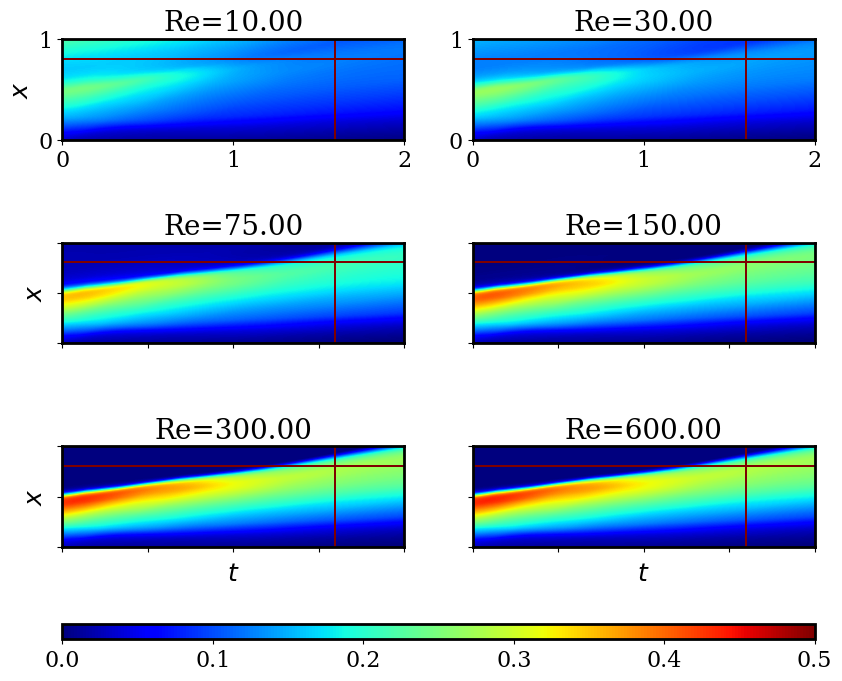

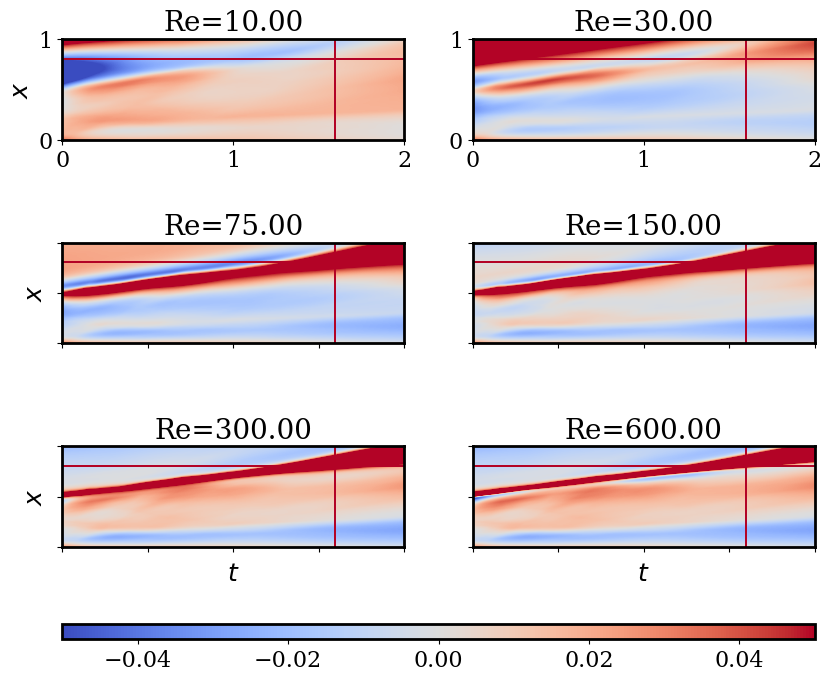

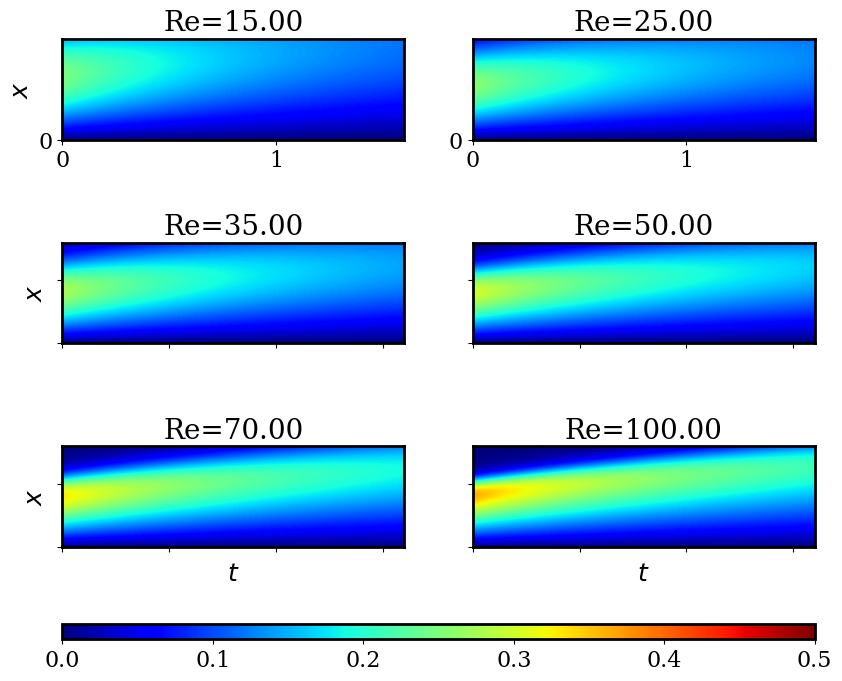

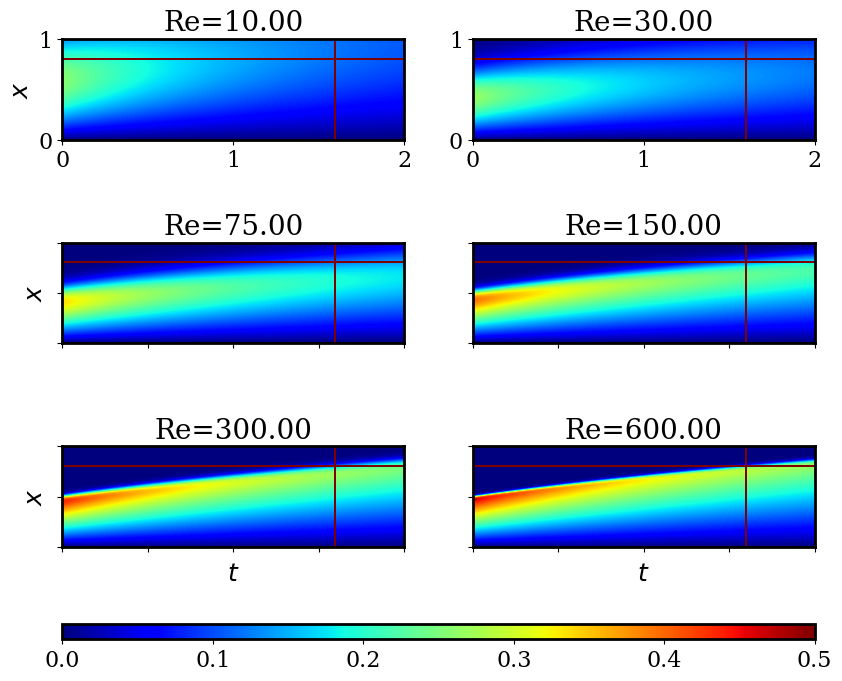

In [8]:
o_res = model([b_test,t_test])

if  scaling is True:
    o_res = u_scaler.inverse_transform(o_res)

test = np.reshape(np.array(o_res),(len( re_test_list),vxn,vtn))

error = test - burgers_array_test

plot_bounds_1d(burgers_array_test[0],test[0],error[0], L_test, T_test, label1= re_test_list[0], vmin1=0, vmax1=0.5,name='low_re'+str(i))
plot_bounds_1d(burgers_array_test[-1],test[-1],error[-1], L_test, T_test, label1= re_test_list[-1], vmin1=0, vmax1=0.5, name='high_re'+str(i))

test[:,:,id_t]=1000
test[:,id_x,:]=1000
burgers_array_test[:,:,id_t]=1000
burgers_array_test[:,id_x,:]=1000
error[:,:,id_t]=1000
error[:,id_x,:]=1000

plot_spcaetime_1d(test[0],test[1],
                  test[2],test[3],
                  test[4],test[5],
                  T_test,L_test,label1= re_test_list,
                  vmin1=0,
                  vmax1=0.5,                      
                  name='prediction'+str(i))

plot_spcaetime_1d(error[0],error[1],
                  error[2],error[3],
                  error[4],error[5],
                  T_test,L_test,
                  colormap='coolwarm',label1= re_test_list,
                  vmin1=-0.05,
                  vmax1=0.05,
                  name='error'+str(i))

plot_spcaetime_1d(burgers_array_train[0],burgers_array_train[1],
                  burgers_array_train[2],burgers_array_train[3],
                  burgers_array_train[4],burgers_array_train[5],
                  T_train,L_train,label1= re_train_list,
                  vmin1=0,
                  vmax1=0.5,                  
                  name='train') 

plot_spcaetime_1d(burgers_array_test[0],burgers_array_test[1],
                  burgers_array_test[2],burgers_array_test[3],
                  burgers_array_test[4],burgers_array_test[5],
                  T_test,L_test,label1= re_test_list,
                  vmin1=0,
                  vmax1=0.5,    
                  name='truth')